In [1]:
# Вебинар 6. Двухуровневые модели рекомендаций


In [2]:
Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [5]:
data = pd.read_csv('../data/retail_train.csv')
item_features = pd.read_csv('../data/product.csv')
user_features = pd.read_csv('../data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [6]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [7]:
recommender = MainRecommender(data_train_lvl_1)

In [8]:
recommender.get_als_recommendations(2375, N=5)

[899624, 1044078, 1106523, 8090537, 1046545]

In [9]:
recommender.get_own_recommendations(2375, N=5)

[948640, 918046, 847962, 907099, 873980]

In [10]:
recommender.get_similar_items_recommendation(2375, N=5)

array([1081177,  893018,  819978, 8020001, 6463877], dtype=int64)

In [11]:
recommender.get_similar_users_recommendation(2375, N=5)

[879373, 820612, 5574377, 12523928, 1026945]

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [12]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [13]:
#Пока пробуем отобрать 50 кандидатов (k=50)
result_lvl_1['own'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))
result_lvl_1['als'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=50))
result_lvl_1['similar_items'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=50))
result_lvl_1['similar_users'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_users_recommendation(x, N=50))

In [14]:
result_lvl_1.head(2)

,user_id,actual,own,als,similar_items,similar_users
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[955587, 1047619, 1062572, 1082212, 821741, 10...","[999999, 1029743, 1106523, 5569230, 916122, 10...","[999999, 841365, 5707857, 977559, 7169088, 102..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[5569230, 5570048, 5569845, 972665, 996087, 86...","[1081177, 1025641, 1007512, 9297615, 5577022, ...","[856942, 1097280, 933102, 835578, 875392, 1015..."


In [15]:
recall_arr = list()
for col in result_lvl_1.iloc[:,2:]:
    print(col, end=': ')
    recall_arr.append(result_lvl_1.apply(lambda row: recall_at_k(row[col], row['actual'], k=50), axis=1).mean())
    print(recall_arr[-1])

own: 0.06506898650542557
als: 0.04945201058828271
similar_items: 0.0169185979158358
similar_users: 0.0022022112810148164


In [16]:
recall_arr =[]
for k in [50, 100, 200, 250, 300, 500]:
    result_lvl_1[f'own_{k}'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=k))
    
    recall_arr.append(result_lvl_1.apply(lambda row: recall_at_k(row[f'own_{k}'], row['actual'], k=k), axis=1).mean())

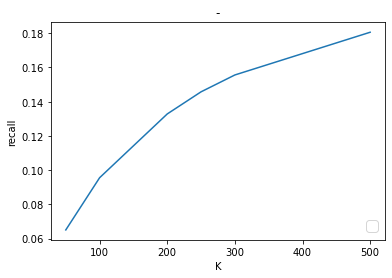

In [17]:
import matplotlib.pyplot as plt

plt.plot([50, 100, 200, 250, 300, 500], recall_arr)

plt.xlabel('K')
plt.ylabel('recall')
plt.title('-')
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [20]:
data_train_lvl_2.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2104867,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,0.0,0.0
2107468,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,0.0,0.0


In [21]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [22]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [28]:
X_train = data_train_lvl_2.merge(item_features, on='item_id', how='left')
X_train = X_train.merge(user_features, on='user_id', how='left')

In [29]:
X_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,...,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,...,SOFT DRINKS,SOFT DRINK BOTTLE NON-CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,...,EGGS,EGGS - LARGE,1 DZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))
users_lvl_2

<ipython-input-32-3f7a98e06cb1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))


,user_id,candidates
0,2070,"[1105426, 1097350, 879194, 948640, 928263, 944..."
1,2021,"[950935, 1119454, 835578, 863762, 1019142, 102..."
2,1753,"[967041, 963686, 948640, 1057168, 942475, 9421..."
3,2120,"[5707857, 999999, 1029743, 1106523, 5569230, 9..."
4,1346,"[1135983, 5569309, 1129982, 5574377, 5569993, ..."
...,...,...
2149,1446,"[6391134, 12487356, 827332, 7024847, 13007435,..."
2150,1784,"[917406, 1131625, 849578, 950935, 886395, 9796..."
2151,436,"[953180, 918046, 915459, 934399, 1092363, 8787..."
2152,1697,"[993838, 922847, 886103, 7442505, 13133916, 10..."


In [45]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

# Пока только warm start
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))

df=pd.DataFrame({'user_id':users_lvl_2.user_id.values.repeat(len(users_lvl_2.candidates[0])),
                 'item_id':np.concatenate(users_lvl_2.candidates.values)})

targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 

targets_lvl_2 = df.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)

targets_lvl_2

,user_id,item_id,target
0,2070,1105426,0.0
1,2070,1097350,0.0
2,2070,879194,0.0
3,2070,948640,0.0
4,2070,928263,0.0
...,...,...,...
111307,1745,903454,0.0
111308,1745,9419888,0.0
111309,1745,1076769,0.0
111310,1745,1092588,0.0


In [46]:
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

In [47]:
targets_lvl_2.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1105426,0.0,69.0,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,1097350,0.0,2468.0,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
2,2070,879194,0.0,69.0,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
3,2070,948640,0.0,1213.0,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
4,2070,928263,0.0,69.0,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


In [48]:
average_check = data_train_lvl_2.groupby(['user_id', 'basket_id'], as_index=False)['sales_value'].sum()
average_check = average_check.groupby('user_id', as_index=False).mean()
average_check = average_check.drop('basket_id', axis=1)
average_check.rename(columns={'sales_value': 'average_check'}, inplace=True)
targets_lvl_2 = targets_lvl_2.merge(average_check, on='user_id', how='left')

In [49]:
num_pur = data_train_lvl_2.merge(item_features, on='item_id', how='left')
num_pur = num_pur.groupby(['user_id', 'department'], as_index=False)['quantity'].sum()
num_pur.rename(columns={'quantity': 'num_pur'}, inplace=True)
num_pur['num_pur'].fillna(0, inplace=True)
targets_lvl_2 = targets_lvl_2.merge(num_pur, on=['user_id', 'department'], how='left')

In [50]:
price = data.loc[:,('item_id', 'quantity', 'sales_value')]
price = price.groupby('item_id', as_index=False)[['quantity', 'sales_value']].sum()
price['price'] = price['sales_value'] / price['quantity']
price = price.drop(['quantity', 'sales_value'], axis=1)
targets_lvl_2 = targets_lvl_2.merge(price, on='item_id', how='left')

In [51]:
goods_per_week = data_train_lvl_2.groupby(['item_id', 'week_no'], as_index=False)['quantity'].sum()
goods_per_week = goods_per_week.groupby('item_id', as_index=False)['quantity'].mean()
goods_per_week.rename(columns={'quantity': 'goods_per_week'}, inplace=True)
goods_per_week['goods_per_week'].fillna(0, inplace=True)


targets_lvl_2 = targets_lvl_2.merge(goods_per_week, on='item_id', how='left')

In [52]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

In [53]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc',
 'average_check',
 'num_pur',
 'price',
 'goods_per_week']

In [54]:
lgb = LGBMClassifier(objective='binary', max_depth=7, categorical_column=cat_feats)
lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [55]:
train_preds

array([[0.95888633, 0.04111367],
       [0.97846588, 0.02153412],
       [0.94545347, 0.05454653],
       ...,
       [0.96229313, 0.03770687],
       [0.8914026 , 0.1085974 ],
       [0.90260089, 0.09739911]])

In [56]:
data_val_lvl_2.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2277416,338,41260573635,636,840173,1,1.99,369,0.0,112,92,0.0,0.0
2277417,338,41260573635,636,1037348,1,0.89,369,-0.3,112,92,0.0,0.0


In [57]:
preds = train_preds[:,1]

In [ ]:
targets_lvl_2

In [ ]:
result = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

In [ ]:
preds = lgb.predict_proba(X_val)[:,1]

In [59]:
targets_lvl_2['pred'] = preds
targets_lvl_2 = targets_lvl_2.sort_values(['user_id', 'pred'], ascending=[False, False])
targets_lvl_2

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,average_check,num_pur,price,goods_per_week,pred
72060,2500,5572308,0.0,1280.0,NUTRITION,National,REFRIGERATED,YOGURT,24 OZ,NaN,...,NaN,NaN,NaN,NaN,NaN,41.700000,6.0,3.117800,1.500000,0.148602
72055,2500,1086061,0.0,1046.0,GROCERY,National,COFFEE,GROUND COFFEE,34.5 OZ,NaN,...,NaN,NaN,NaN,NaN,NaN,41.700000,84.0,5.656282,3.250000,0.147023
72057,2500,1065538,1.0,239.0,GROCERY,National,BEERS/ALES,BEERALEMALT LIQUORS,12OZ,NaN,...,NaN,NaN,NaN,NaN,NaN,41.700000,84.0,15.771750,2.666667,0.119660
72058,2500,1065538,1.0,239.0,GROCERY,National,BEERS/ALES,BEERALEMALT LIQUORS,12OZ,NaN,...,NaN,NaN,NaN,NaN,NaN,41.700000,84.0,15.771750,2.666667,0.119660
72059,2500,1065538,1.0,239.0,GROCERY,National,BEERS/ALES,BEERALEMALT LIQUORS,12OZ,NaN,...,NaN,NaN,NaN,NaN,NaN,41.700000,84.0,15.771750,2.666667,0.119660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46190,1,911454,0.0,317.0,GROCERY,National,CHEESE,IWS SINGLE CHEESE,16 OZ,65+,...,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,48.825714,103.0,3.696779,1.250000,0.133462
46202,1,7431134,0.0,523.0,PASTRY,National,PIES,PIES: FRUIT/NUT,,65+,...,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,48.825714,4.0,3.628103,1.000000,0.126864
46191,1,7152319,0.0,2627.0,GROCERY,National,DOMESTIC WINE,POPULAR 750ML WINES,4/187 ML,65+,...,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,48.825714,103.0,6.901111,NaN,0.065841
46198,1,979674,0.0,111.0,DRUG GM,National,CIGARETTES,CIGARETTES,CTN,65+,...,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,48.825714,13.0,35.840000,1.200000,0.037413


In [ ]:
valid_preds = X_val.loc[:, ['user_id', 'item_id']]
valid_preds['preds'] = preds
valid_preds.sort_values(['preds'], inplace=True)

In [60]:
preds_lgbm = targets_lvl_2[['user_id', 'item_id']].copy().drop_duplicates()
preds_lgbm = preds_lgbm.groupby('user_id')['item_id'].apply(list).reset_index()
preds_lgbm

,user_id,item_id
0,1,"[9527558, 8293439, 9655212, 856942, 12385374, ..."
1,2,"[898847, 1110244, 907099, 862725, 5567582, 820..."
2,4,"[883932, 908283, 1079528, 5568447, 1075368, 11..."
3,6,"[900802, 1098844, 12757544, 1098284, 878715, 8..."
4,7,"[1122358, 9338009, 990897, 983316, 1010051, 87..."
...,...,...
2146,2496,"[1056509, 5580577, 1069003, 865511, 5591083, 1..."
2147,2497,"[1135834, 1050741, 849202, 1138292, 864279, 10..."
2148,2498,"[829621, 9837092, 849578, 1022066, 5576075, 99..."
2149,2499,"[889989, 835819, 9523059, 6904613, 901460, 101..."


In [74]:
result = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result.rename(columns={'item_id': 'actual'}, inplace=True)
result = result[result['user_id'].isin(train_users)]

result = result.merge(preds_lgbm, on='user_id', how='left')
result.rename(columns={'item_id': 'lgb'}, inplace=True)

result.head(2)

,user_id,actual,lgb
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[9527558, 8293439, 9655212, 856942, 12385374, ..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...",NaN


In [77]:
result = result[result['lgb'].notna()]

In [81]:
result.apply(lambda row: precision_at_k(row['lgb'], row['actual'], k=5), axis=1).mean()

0.1821409921671001

### Финальный проект

Мы уже прошли всю необходимуб теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - precision@5. Порог для уcпешной сдачи проекта precision@5 > 0.27%
- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно, но крайне желательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и csv файл с рекомендациями 